# EAM potentials 2: Hands on

In [1]:
from pyiron import Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12})

In [2]:
pr = Project(".")

## Training data

In [3]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,768254,finished,None,AlEnergyBasedWeight,/AlEnergyBasedWeight,/nfshome/leimeroth/git_projects/potentials-workshop-2022/,potentials/01-EAM/,2022-09-02 08:38:42.271734,2022-09-02 08:43:45.499587,303.0,pyiron@mogli243#1,Atomicrex,0.4,None,None


### Add training data
Instead of simply loading the training data weights are assigned to the structures based on their energy this time. Additionally the structure with a very high atomic volume is filtered out.  
Structures with low energy get a higher weight than structures with high energy.
It can also help to increase the weights of special properties or important structures to put a focus on things that are important for the scope of the potential.
For a list of a all properties that can be fitted refer to the atomicrex website https://www.atomicrex.org/properties.html

In [4]:
def get_e_weight(E_S, Delta=1.0, N=2):
    return 1 / (E_S + Delta) ** N

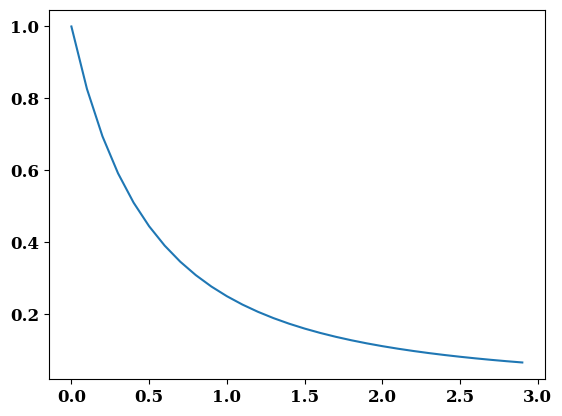

In [5]:
E_S = np.arange(0, 3, 0.1)
plt.plot(E_S, get_e_weight(E_S))

In [6]:
tc = pr['../../introduction/training/Al_basic_atomicrex'] ## Load the TrainingContainer
job = pr.create.job.Atomicrex("AlEnergyBasedWeight", delete_existing_job=True)

In [7]:
i=0
for s, energy, forces, symbols in tc.iter("energy", "forces", "symbols"):
    natoms = len(s)
    e = energy / natoms
    weight = get_e_weight(e+3.5) # add approx. equilibrium energy of Al
    job.structures.add_structure(structure=s, identifier=f"{i}", relative_weight=weight) # set weight for the structure
    job.structures.add_scalar_fit_property(prop="atomic-energy", target_val=e,)
    job.structures.add_vector_fit_property(prop="atomic-forces", target_val=forces)
    i += 1

## Fitting

### Set the potential type

In [8]:
job.potential = job.factories.potentials.eam_potential()

### Define functions

In [9]:
# morse A is the original rather simple morse potential
morseA = job.factories.functions.morse_A("MorseA", D0=0.15, r0=3.0, alpha=2.0, species=["Al", "Al"])
morseA.screening = job.factories.functions.x_pow_n_cutoff("morseScreen", cutoff=7.6, species=["Al", "Al"])

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:xlabel='r [$\\AA$]', ylabel='func(r)'>)

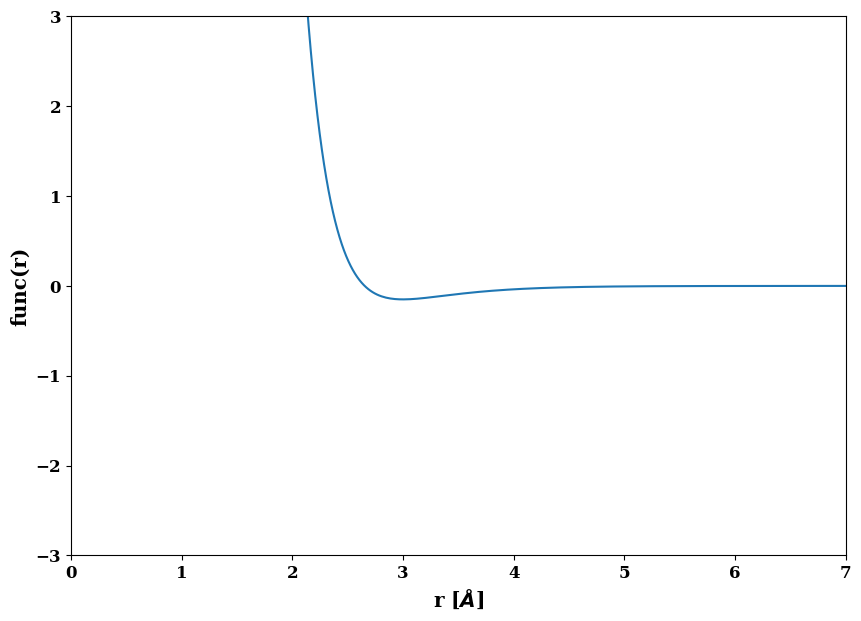

In [10]:
morseA.plot()

Electron density as used by Mishin in his Cu potential (https://doi.org/10.1103/PhysRevB.63.224106, Gaussian + exp(-$\beta$r term)

In [11]:
rho = job.factories.functions.MishinCuRho(identifier="Rho", a=1.0, r1=-1, r2=0.0, beta1=1.0, beta2=3.0, species=["Al", "Al"])
rho.screening = job.factories.functions.x_pow_n_cutoff("RhoScreen", cutoff=7.6, species=["Al", "Al"])

In [12]:
F = job.factories.functions.user_function(identifier="F", input_variable="rho", species=["Al"])
# User function for embedding term
F = job.factories.functions.user_function(identifier="F", input_variable="r")
F.expression = "-A*sqrt(r)"
F.derivative = "-A/(2*sqrt(r))"
F.parameters.add_parameter("A", start_val=2.3, min_val=0.0)

In [13]:
job.potential.pair_interactions[morseA.identifier] = morseA
job.potential.electron_densities[rho.identifier] = rho
job.potential.embedding_energies[F.identifier] = F

job.input.fit_algorithm = job.factories.algorithms.ar_lbfgs(max_iter=500, gradient_epsilon=1e-9)

job.run()

The job AlEnergyBasedWeight was saved and received the ID: 768254


### Examples for alternative minimizers

Local:
```
job.input.fit_algorithm = job.factories.algorithms.ln_neldermead(max_iter=10000)
```
nelder mead is a bit more robust than the LBFGS implementation in atomicrex
It is gradient free, so each iteration is much quicker, but more iterations are needed

Global:
```
job.input.fit_algorithm = job.factories.algorithms.gn_esch(max_iter=10000)
```
ESCH is an evolutionary algorithm. To use it all parameters need a min and a max value

(<Figure size 800x1800 with 3 Axes>,
 array([[<AxesSubplot:title={'center':'Al F'}, xlabel='$\\rho $ [a.u.]'>],
        [<AxesSubplot:title={'center':'Al rho_AlAl'}, xlabel='r [$\\AA$]'>],
        [<AxesSubplot:title={'center':'Al V_AlAl'}, xlabel='r [$\\AA$]'>]],
       dtype=object))

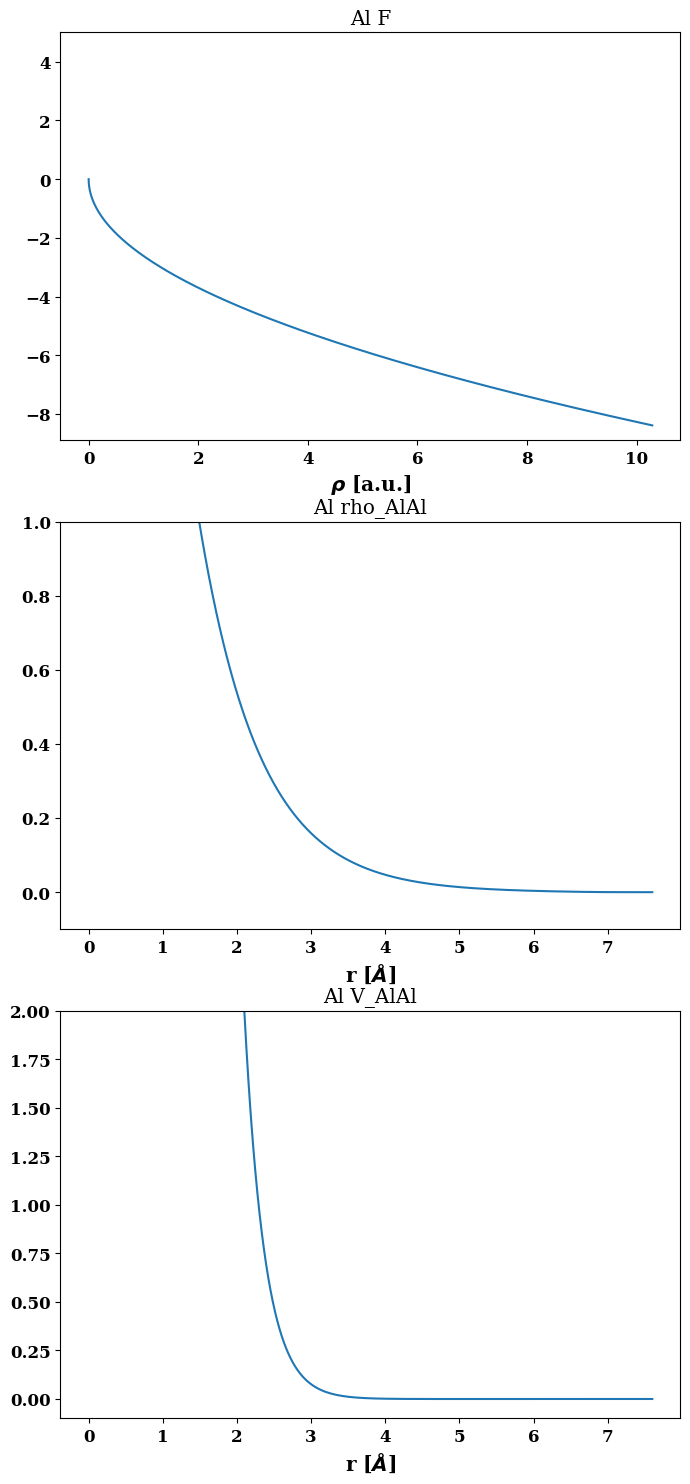

In [14]:
job.plot_final_potential()

509.4135409319779

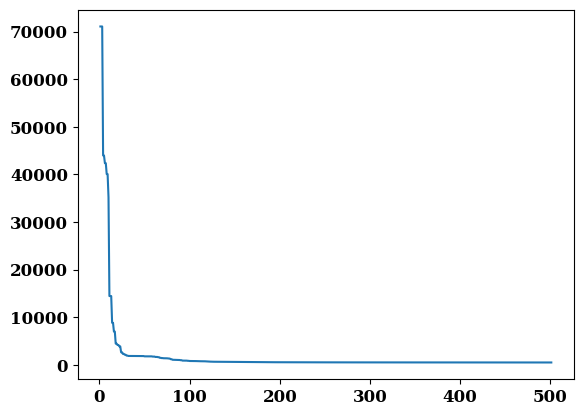

In [15]:
plt.plot(job.output.iterations, job.output.residual)
job.output.residual[-1]

In [16]:
plots = job.plot

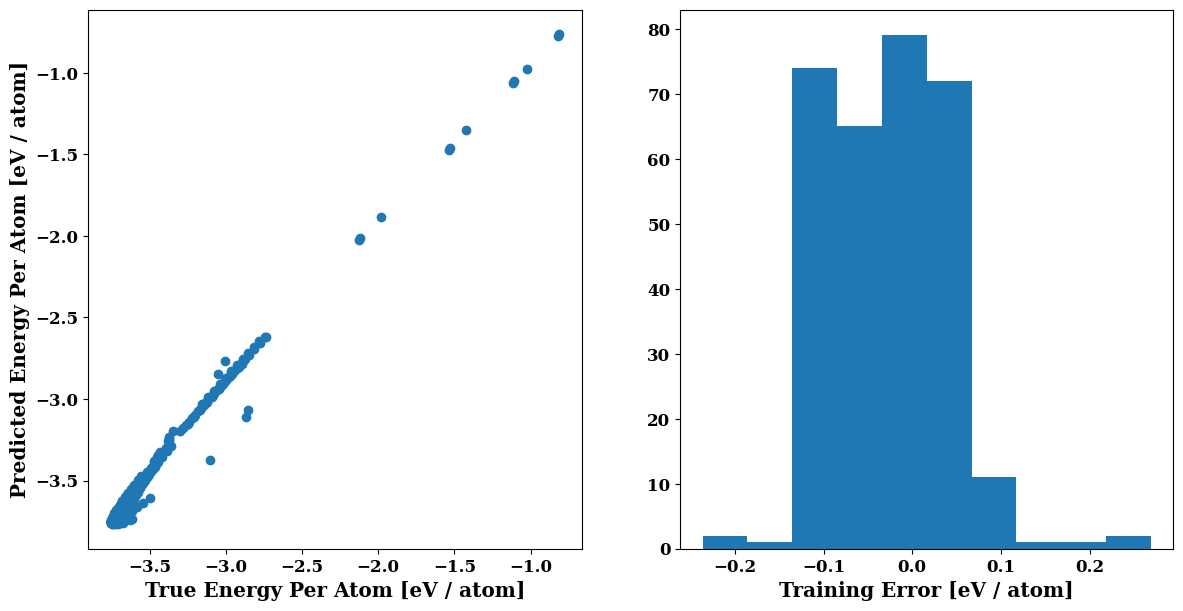

In [17]:
plt.figure(figsize=(14,7))
plots.energy_scatter_histogram()

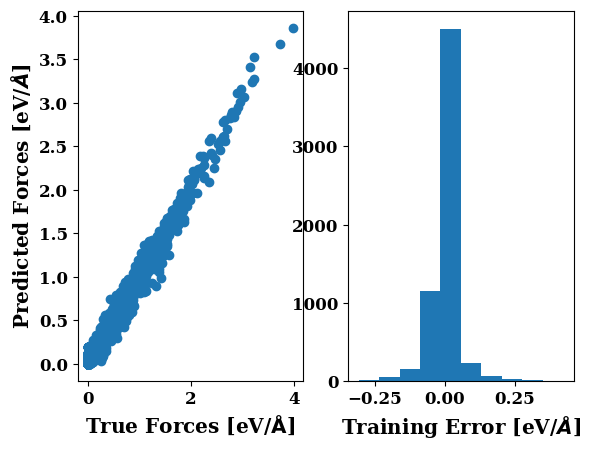

In [18]:
plots.force_scatter_histogram()

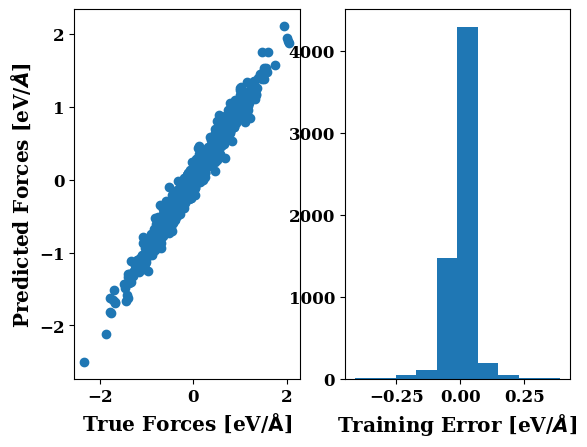

In [19]:
plots.force_scatter_histogram(axis=0)

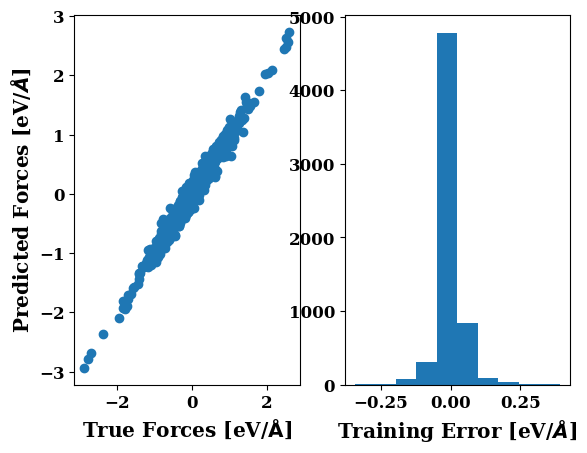

In [20]:
plots.force_scatter_histogram(axis=1)

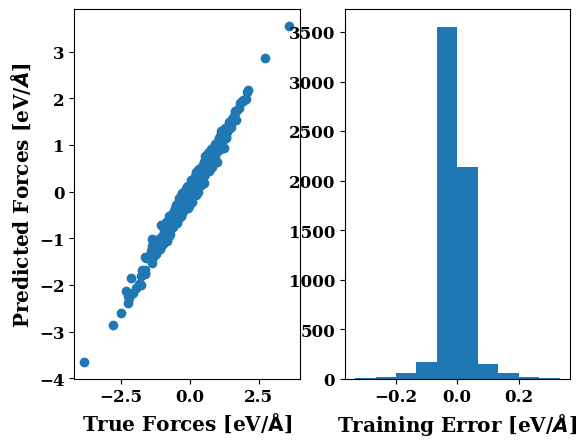

In [21]:
plots.force_scatter_histogram(axis=2)

## Appendix

For the potential used in the validation and phase diagram calculations a different functional form was used.

The Al potential followed the same formalism as used by Mishin in his Cu potential https://doi.org/10.1103/PhysRevB.63.224106.
For Li and AlLi terms the pair interaction was described using a morse-C potential, while cubic splines were used for the electron densities.
The Li embedding term was a modified version of that used by Mishin that is implemented in the atomicrex code.

To be able to guarantee certain properties the parameters of these functions were constrained.
EAM potentials are invariant under the transformations:  
$\rho(r)\rightarrow s\rho(r)$, $F(\bar\rho)\rightarrow F(\bar\rho / s)$ and $F(\bar\rho)\rightarrow F(\bar\rho) - g\bar\rho$, $V(r)\rightarrow V(r)+2g\rho(r)$

To uniquely define them the condition:
$\sum_m N_m \rho(r_m) = 1$ was applied. Here $N_m$ is the number of neighbors of the equilibrium structure in shell m.


A perfect lattice constant can be obtained by applying the mechanical equilibrium condition:  
$\frac{1}{2} \sum_m N_m V(r_m)' r_m + F_0' \sum_m N_m \rho(r_m)' r_m$ where $F0$ is the value of the embedding function at the equilibrium structures electron density, i.e. $F(1)$ if the above condition is applied.

The correct equilibrium energy $E_0$ can be guaranteed with:  
$F_0 = E_0-\frac{1}{2}\sum_m N_m V(r_m)$

An exact fit to the bulk modulus can be achieved by applying:  
$\frac{1}{2}\sum_m N_mV(r_m)''r_m^2 + F_0' \sum_m N_m \rho(r_m)'' R_m^2 + F_0''(\sum_m N_m \rho(r_m)' r_m)^2 $

These (or similar equations) have to be solved with respect to some parameter in the function. A simple example is the electron density which can be constrained to 1 by multiplying the whole function with some factor c after its evaluation for the equilibrium structure.
This then looks f.e. like this in the atomicrex input file (xml format):

```
        <constraint id="one_constrain_rhoSpline_LiLi" dependent-dof="EAM.rho_LiLi.cfactor_rhoSpline_LiLi.const">
            <expression>1 / ( + 8 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.2.966650281143688} + 6 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.3.425592676819574} + 12 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.4.844519622724197} + 24 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.5.6807027967998565} + 8 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.5.933300562287376} + 6 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.6.851185353639148} + 24 * {EAM.rho_LiLi.rhoSpline_LiLi:eval.7.465906149994755})</expression>
        </constraint>
```
The block contains an identifier, the "path" to the parameter that is constrained and the expression that is applied to constrain it.
In the pyiron interface such constraints can be added using as follows:

In [22]:
job.input.parameter_constraints.add_constraint(
    identifier="Identifier",
    dependent_dof="The parameter or degree of freedom to constrain",
    expression="Expression that is used to determine the value of the parameter, parsed using muparser"
)

If any questions regarding the interface/feature requests/problems occur after the workshop feel free to send me a mail leimeroth@mm.tu-darmstadt.de